# Import Library

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd
import numpy as np
import random

In [2]:
# Display 100 columns for pandas
pd.set_option('display.max_columns', 100)

# Open, Read, and Save to data frame
X_train = 'train_features.csv'
X_test = 'test_features.csv'
y_train = 'train_labels.csv'

X_train = pd.read_csv(X_train)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train)

# Check columns to check the what type of data
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Feature Engineer

In [3]:
# Returns True or False if there's construction
X_train['is_construct'] = X_train['construction_year'] != 0
X_test['is_construct'] = X_test['construction_year'] != 0
##############

# Returns water per person
X_train['Water_per_person'] = X_train['amount_tsh']/X_train['population']
X_test['Water_per_person'] = X_test['amount_tsh']/X_test['population']

# Dividing by 0 creates inf values - replace with nan
X_train['Water_per_person'] = X_train['Water_per_person'].replace([np.inf, -np.inf], np.nan)
X_test['Water_per_person'] = X_test['Water_per_person'].replace([np.inf, -np.inf], np.nan)

# Replace nan with 0
X_train['Water_per_person'] = X_train['Water_per_person'].replace(np.nan, 0)
X_test['Water_per_person'] = X_test['Water_per_person'].replace(np.nan, 0)
###############



################

# Change to panda date time to extract week and month
X_train['date_recorded'] = pd.to_datetime(X_train['date_recorded'], infer_datetime_format=True)
X_test['date_recorded'] = pd.to_datetime(X_test['date_recorded'], infer_datetime_format=True)
X_train['week'] = X_train['date_recorded'].apply(lambda x: x.week)
X_test['week'] = X_test['date_recorded'].apply(lambda x: x.week)
X_train['month'] = X_train['date_recorded'].apply(lambda x: x.month)
X_test['month'] = X_test['date_recorded'].apply(lambda x: x.month)
X_train['year'] = X_train['date_recorded'].apply(lambda x: x.year)
X_test['year'] = X_test['date_recorded'].apply(lambda x: x.year)
######################

# Get the age and replace with 0 if construction_year is 0
X_train['age'] = X_train['year'] - X_train['construction_year']
X_train['age'].loc[X_train['age'] == X_train['year']] = 0

X_test['age'] = X_test['year'] - X_test['construction_year']
X_test['age'].loc[X_test['age'] == X_test['year']] = 0
# ###########################

# Change back to string or else RandomForestClassifier can't process
X_train['date_recorded']= X_train['date_recorded'].astype(str)
X_test['date_recorded'] = X_test['date_recorded'].astype(str)



C:\Users\Dustin\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Fill NaN

In [4]:
# Fill NaN - First need to concat X_train and X_test to get the mean then fill it 
X_train['public_meeting'] = X_train['public_meeting'].fillna(lambda x: random.choice(X_train[X_train['public_meeting'] != np.nan])['public_meeting'])
X_test['public_meeting'] = X_test['public_meeting'].fillna(lambda x: random.choice(X_test[X_test['public_meeting'] != np.nan])['public_meeting'])

X_train['permit'] = X_train['permit'].fillna(lambda x: random.choice(X_train[X_train['permit'] != np.nan])['permit'])
X_test['permit'] = X_test['permit'].fillna(lambda x: random.choice(X_test[X_test['permit'] != np.nan])['permit'])

# Replace 0 with the mean

In [5]:
X_train['age'] = X_train['age'].replace(0, round(pd.concat([X_train,X_test])['age'].mean()))
X_test['age'] = X_test['age'].replace(0, round(pd.concat([X_train,X_test])['age'].mean()))

X_train['gps_height'] = X_train['gps_height'].replace(0, round(pd.concat([X_train,X_test])['gps_height'].mean()))
X_test['gps_height'] = X_test['gps_height'].replace(0, round(pd.concat([X_train,X_test])['gps_height'].mean()))

# Drop Columns

In [6]:
# Drop columns due to 1) Redundant and 2) Low Permutation Importance
drop_cols = ['quantity_group','construction_year','recorded_by','id','num_private',
             'amount_tsh', 'wpt_name','subvillage','management_group'] # Test 1
# drop_cols = ['quantity_group','construction_year','recorded_by','id','num_private',
#              'amount_tsh', 'wpt_name','subvillage','public_meeting','is_construct',
#              'year','month','region_code','extraction_type_group','management_group',
#              'source_class']
X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)
y_train = y_train.drop(columns='id')

# Split to training and validation sets

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.2)

# Encode, Fit, Transform, and Scale

In [8]:
# Encode categorical features
encoder = ce.OrdinalEncoder()

# Fit & Transform
X_train = encoder.fit_transform(X_train)

# Scale - Only the continuous. I found scaling all features made prediction worse

continuous_col = ['population','gps_height','week','month','year','age'] # Test 1

scaled = MinMaxScaler()
X_train[continuous_col] = scaled.fit_transform(X_train[continuous_col])


C:\Users\Dustin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Randomized Search Cross-Validation

In [9]:
# Define parameters for the model
param_distributions = {
    'n_estimators': [300,325,350], 
    'max_depth': [15,20,25]
}

# Define the model and input inside RSCV
model = RandomForestClassifier(n_jobs=-1, random_state=42)

# RSCV
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=9,
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42
)

# Fit to training data
search.fit(X_train, y_train)

# Accuracy score
print('Training Accuracy Score:', search.best_score_) # 0.8101 #0.8100

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  2.7min remaining:   46.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  2.8min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.1min finished
C:\Users\Dustin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training Accuracy Score: 0.810016835016835


In [10]:
# Read the top 5 results as a dataframe sorted by rank_test_score
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,27.836347,1.462738,2.713542,2.214116,325,20,"{'n_estimators': 325, 'max_depth': 20}",0.810646,0.810731,0.809113,0.812270,0.807324,0.810017,0.001676,1,0.962751,0.963172,0.962464,0.964937,0.964411,0.963547,0.000962
5,29.955481,0.845228,2.002044,1.245059,350,20,"{'n_estimators': 350, 'max_depth': 20}",0.810120,0.810731,0.808587,0.812059,0.807745,0.809848,0.001533,2,0.962908,0.962988,0.962832,0.964989,0.964753,0.963694,0.000965
3,26.014839,2.034217,3.645449,1.839697,300,20,"{'n_estimators': 300, 'max_depth': 20}",0.811172,0.810416,0.807745,0.812165,0.807429,0.809785,0.001881,3,0.962751,0.962988,0.962938,0.964989,0.964674,0.963668,0.000959
6,27.552906,1.637112,2.915801,1.687964,300,25,"{'n_estimators': 300, 'max_depth': 25}",0.806438,0.808522,0.806587,0.809429,0.804062,0.807008,0.001862,4,0.994318,0.995002,0.994450,0.994555,0.994450,0.994555,0.000236
7,28.981485,0.692959,2.281897,0.234649,325,25,"{'n_estimators': 325, 'max_depth': 25}",0.806333,0.808311,0.806693,0.809113,0.803010,0.806692,0.002106,5,0.994370,0.995002,0.994476,0.994450,0.994529,0.994565,0.000224


# Validate Accuracy of Test Set

In [11]:
# Fit X_val
X_val = encoder.transform(X_val)

# Partial scale x_val
X_val[continuous_col] = scaled.fit_transform(X_val[continuous_col])


C:\Users\Dustin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
# Test Validation
best = search.best_estimator_
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val, y_pred)) # 0.81397 #0.81355

Validation Set Accuracy Score: 0.8135521885521886


In [13]:
import eli5
from eli5.sklearn import PermutationImportance

# Instantiate. prefit means cv already done
permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', n_iter=3,
                                 random_state=42)
# Fit to test validation set
permuter.fit(X_val, y_val)

# Display Feature Importance
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1028 ± 0.0097,quantity
0.0166 ± 0.0030,age
0.0148 ± 0.0021,waterpoint_type
0.0144 ± 0.0018,longitude
0.0136 ± 0.0025,extraction_type_class
0.0121 ± 0.0034,Water_per_person
0.0108 ± 0.0005,latitude
0.0063 ± 0.0007,population
0.0058 ± 0.0023,gps_height
0.0056 ± 0.0002,funder


# Predict X_test

In [17]:
# Test - X_Test
best = search.best_estimator_
X_test = encoder.transform(X_test)

# Partial scale x_test
X_test[continuous_col] = scaled.fit_transform(X_test[continuous_col])
y_pred_test = best.predict(X_test) # 0.81821 #0.81905

C:\Users\Dustin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Save Predictions

In [ ]:
### SUBMISSION ###

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred_test
submission.to_csv('Best-submission_3.csv', index=False)

# Visualization

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

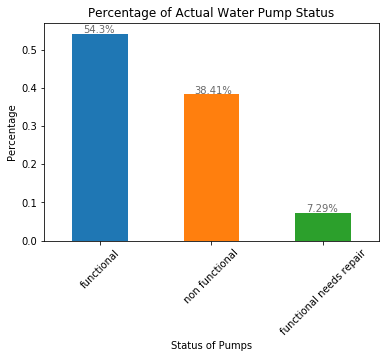

In [15]:
# Plot

# Plot the percentages of actual water pump status'
ax = y_train['status_group'].value_counts(normalize=True).plot(kind='bar')

# Set title and labels
ax.set_title('Percentage of Actual Water Pump Status')
ax.set_xlabel('Status of Pumps')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45)

# Annotate
totals=[]
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+.001,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10, color='dimgrey')

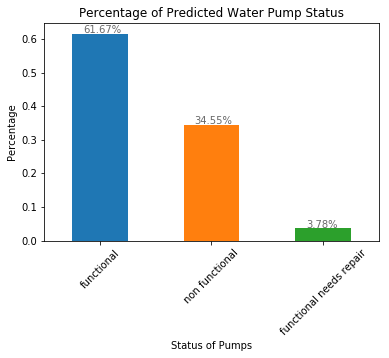

In [18]:
# Plot

# Save Predictions to dataframe
y_pred_plot = pd.DataFrame(y_pred_test, columns=['status_group'])

# Plot the percentages of actual water pump status'
ax = y_pred_plot['status_group'].value_counts(normalize=True).plot(kind='bar')

# Set title and labels
ax.set_title('Percentage of Predicted Water Pump Status')
ax.set_xlabel('Status of Pumps')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45)

# Annotate
totals=[]
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+.001,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10, color='dimgrey')

In [19]:
# Read in data again
X_train_plot = 'train_features.csv'
y_train_plot = 'train_labels.csv'

X_train_plot = pd.read_csv(X_train_plot)
y_train_plot = pd.read_csv(y_train_plot)

# Merge
df = X_train_plot.merge(y_train_plot)
print(df.shape)
df.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [20]:
df_region = df.dropna(subset=['region'])
df_region = df_region.loc[:, ['region', 'status_group']]
df_region.head()

,region,status_group
0,Iringa,functional
1,Mara,functional
2,Manyara,functional
3,Mtwara,non functional
4,Kagera,functional


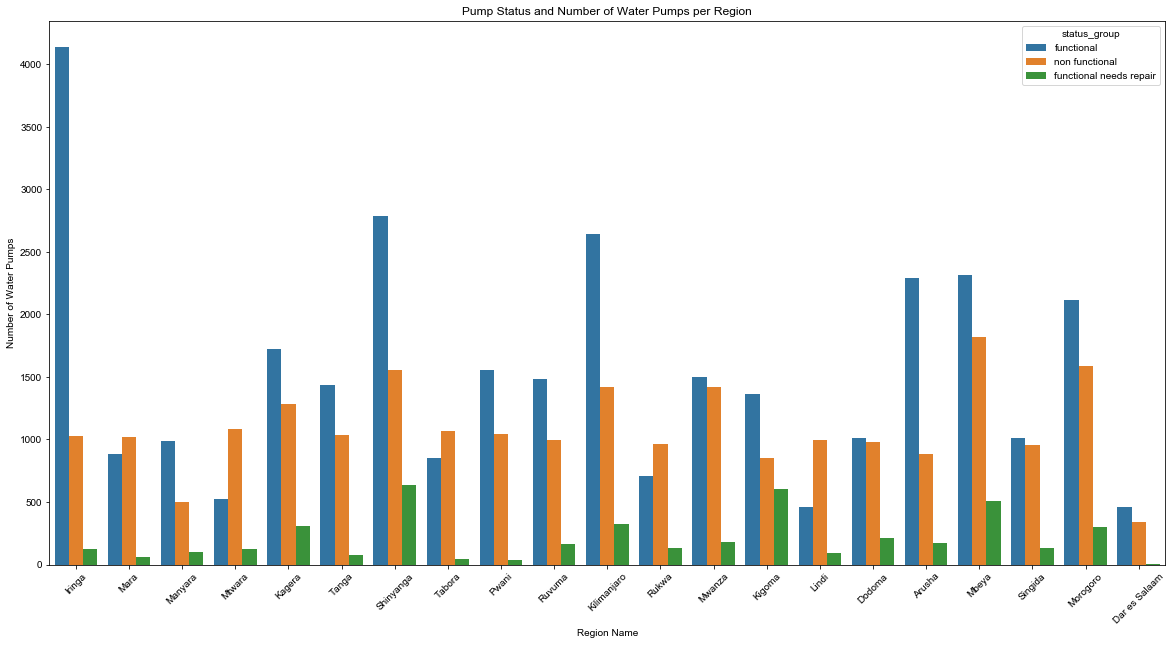

In [21]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_region, x='region', hue='status_group')

ax.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);